# Exploring Machine Learning on Quantopian
Recently, Quantopian’s Chief Investment Officer, Jonathan Larkin, shared an industry insider’s overview of the [professional quant equity workflow](http://blog.quantopian.com/a-professional-quant-equity-workflow/). This workflow is comprised of distinct stages including: (1) Universe Definition, (2) Alpha Discovery, (3) Alpha Combination, (4) Portfolio Construction and (5) Trading.

This Notebook focuses on stage 3: Alpha Combination. At this stage, Machine Learning is an intuitive choice as we have abstracted the problem to such a degree that it is now a classic classification (or regression) problem which ML is very good at solving and coming up with an alpha combination that is predictive.

As you will see, there is a lot of code here setting up a factor library and some data wrangling to get everything into shape. The details of this part are perhaps not quite as interesting so feel free to skip directly to ["Training our ML pipeline"](#training) where we have everything in place to train and test our classifier.

## Overview
1. Define trading universe to use ([Q500US and Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us)).
2. Define alphas (implemented in [Pipeline](https://www.quantopian.com/tutorials/pipeline)).
3. Run pipeline.
4. Split into train and test set.
5. Preprocess data (rank alphas, subsample, align alphas with future returns, impute, scale).
6. Train Machine Learning classifier ([AdaBoost from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)).
7. Evaluate Machine Learning classifier on test set.

Note that one important limitation is that we only train and test on static (i.e. fixed-in-time) data. Thus, you can not directly do the same in an algorithm. In principle, this is possible and will be the next step but it makes sense to first focus on just the ML in a more direct way to get a good intuition about the workflow and how to develop a competitive ML pipeline.

### Disclaimer
This workflow is still a bit rough around the edges. We are working on improving it and adding better educational materials. This serves as a sneak-peek for the curious and adventurous.

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

## Definition of some commonly used factors
The factors below are a small collection of commonly used alphas that were coded by Gil Wassermann. I will post a separate Notebook with the full collection and more descriptions of them. Ultimately we will put these into a library you can just import to avoid the wall of text. If you want to understand more about pipeline, read the [tutorial](https://www.quantopian.com/tutorials/pipeline).

Also note the `Earnings_Quality` alpha which uses [Zacks Earnings Surprises](https://www.quantopian.com/data/zacks/earnings_surprises), a [new source from our partners](https://www.quantopian.com/data).

The details of these factors are not the focus of this Notebook so feel free to just [skip](#universe) this cell.

In [2]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
        
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors

<a></a></a>

## Define universe and select factors to use
We will screen our universe using the new [Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us) and hand-pick a few alphas from the list above. We encourage you to play around with the factors.

In [3]:
universe = Q1500US()

factors = make_factors()

## Define and build the pipeline
Next we have to build the pipeline. In addition to the factors defined above, we need the forward returns we want to predict. In this Notebook we will predict 5-day returns and train our model on daily data. You can also subsample the data to e.g. weekly to not have overlapping return periods but we omit this here.

In [4]:
n_fwd_days = 5 # number of days to compute returns over

In [5]:
class helper:
    default_feature = []
    reduced_columns = []

In [6]:
def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    sma_20 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=20, mask=universe)  
    sma_200 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=200, mask=universe)
      
    
    
    factor_ranks = {name: f().rank(mask=universe) for name, f in factors.iteritems()}
    
    for col in factor_ranks:
        helper.default_feature.append(col)
    
    factor_ranks['long'] = (sma_20 >= sma_200)
    
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

In [7]:
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

## Run the pipeline

In [8]:
start_timer = time()
start = pd.Timestamp("2018-03-06")
end = pd.Timestamp("2018-07-7")
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [9]:
helper.default_feature

['Moneyflow Volume 5D',
 'Earnings Quality',
 'Return on Invest Capital',
 '39 Week Returns',
 'EBITDA Yield',
 'Asset to Equity Ratio',
 'Mean Reversion 1M',
 'Trendline',
 'MACD Signal Line',
 'Asset Growth 3M',
 'Capex to Cashflows',
 'Net Income Margin',
 'EBIT to Assets',
 'Vol 3M',
 'Price Momentum 3M',
 'Operating Cashflows to Assets',
 'Working Capital to Assets',
 'Price Oscillator']

In [10]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 51.14 secs


In [11]:
np.shape(results)

(129955, 20)

In [12]:
results

# DROP LONG FROM RESULST
long_ = results['long']
results = results.drop('long', axis = 1)

results

39 Week Returns  \
date                      security                                
2018-03-06 00:00:00+00:00 Equity(2 [ARNC])                299.0   
                          Equity(24 [AAPL])              1017.0   
                          Equity(53 [ABMD])              1446.0   
                          Equity(62 [ABT])               1231.0   
                          Equity(67 [ADSK])              1124.0   
                          Equity(76 [TAP])                195.0   
                          Equity(114 [ADBE])             1348.0   
                          Equity(122 [ADI])               897.0   
                          Equity(128 [ADM])               408.0   
                          Equity(161 [AEP])               524.0   
                          Equity(166 [AES])               511.0   
                          Equity(168 [AET])              1165.0   
                          Equity(185 [AFL])               925.0   
                          Equity(197 [AGCO])              563.0   
                          Equity(216 [HES])               473.0   
                          Equity(239 [AIG])               396.0   
                          Equity(266 [AJG])              1046.0   
                          Equity(270 [AKRX])               20.0   
                          Equity(300 [ALK])               122.0   
                          Equity(301 [ALKS])              642.0   
                          Equity(337 [AMAT])             1235.0   
                          Equity(351 [AMD])               248.0   
                          Equity(353 [AME])              1131.0   
                          Equity(357 [TWX])               407.0   
                          Equity(368 [AMGN])              923.0   
                          Equity(371 [TVTY])             1185.0   
                          Equity(410 [AN])                829.0   
                          Equity(438 [AON])               885.0   
                          Equity(448 [APA])               112.0   
                          Equity(455 [APC])               582.0   
...                                                         ...   
2018-07-09 00:00:00+00:00 Equity(50903 [APPN])           1219.0   
                          Equity(50910 [JHG])             241.0   
                          Equity(50970 [ATUS])             25.0   
                          Equity(51012 [BHGE])            383.0   
                          Equity(51016 [JBGS])            724.0   
                          Equity(51046 [BHF])              58.0   
                          Equity(51079 [RDFN])            289.0   
                          Equity(51091 [VNTR])             99.0   
                          Equity(51157 [DWDP])              NaN   
                          Equity(51205 [BKI])               NaN   
                          Equity(51231 [ROKU])              NaN   
                          Equity(51268 [SWCH])              NaN   
                          Equity(51281 [CARG])              NaN   
                          Equity(51314 [MDB])               NaN   
                          Equity(51467 [SFIX])              NaN   
                          Equity(51468 [SAIL])              NaN   
                          Equity(51494 [DLPH])              NaN   
                          Equity(51634 [AVYA])              NaN   
                          Equity(51649 [ADT])               NaN   
                          Equity(51689 [PAGS])              NaN   
                          Equity(51734 [VICI])              NaN   
                          Equity(51832 [ZS])                NaN   
                          Equity(51854 [DBX])               NaN   
                          Equity(51895 [SPOT])              NaN   
                          Equity(51937 [DOCU])              NaN   
                          Equity(51942 [PVTL])              NaN   
                          Equity(51966 [APY])               NaN   
                          Eq

In [13]:
results.shape

(129955, 19)

As you can see, running pipeline gives us factors for every day and every security, ranked relative to each other. We assume that the order of individual factors might carry some weak predictive power on future returns. The question then becomes: how can we combine these weakly predictive factors in a clever way to get a single mega-alpha which is hopefully more predictive.

This is an important milestone. We have our ranked factor values on each day for each stock. Ranking is not absolutely necessary but has several benefits:

* it increases robustness to outliers,
* we mostly care about the relative ordering rather than the absolute values.

Also note the `Returns` column. These are the values we want to predict given the factor ranks.

Next, we are doing some additional transformations to our data:

1. Shift factor ranks to align with future returns `n_fwd_days` days in the future.
2. Find the top and bottom 30 percentile stocks by their returns. Essentially, we only care about relative movement of stocks. If we later short stocks that go down and long stocks going up relative to each other, it doesn't matter if e.g. all stocks are going down in absolute terms. Moverover, we are ignoring stocks that did not move that much (i.e. 30th to 70th percentile) to only train the classifier on those that provided strong signal. 
3. We also binarize the returns by their percentile to turn our ML problem into a classification one.

`shift_mask_data()` is a utility function that does all of these.

In [14]:
def shift_mask_data(X, Y, upper_percentile=70, lower_percentile=30, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
    #print("mama KIre ")
    #print(upper)
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

After we have our helper function to align our data properly we pass our factor ranks to it. You might wonder why we have to do the `swapaxes` thing below rather than just using `pandas` logic. The reason is that this way we can use the same `shift_mask_data()` function inside of a factor where we do not have access to a Pandas `DataFrame`. More on that in a future notebook.

In [15]:
# Massage data to be in the form expected by shift_mask_data()
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)

#np.shape(returns)
X

array([[[  299.,   183.,  1102., ...,   418.,   869.,   848.],
        [ 1017.,  1372.,   899., ...,  1289.,   458.,   527.],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ..., 
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[  281.,   186.,  1100., ...,   419.,   870.,   847.],
        [  980.,  1371.,   899., ...,  1289.,   450.,   527.],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ..., 
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[  287.,   187.,  1099., ...,   419.,   882.,   846.],
        [  911.,  1369.,   899., ...,  1288.,   468.,   527.],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ..., 
        [

In [16]:
results_wo_returns.index = results_wo_returns.index.set_levels(results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 1, )


In [17]:
results_wo_returns.index = results_wo_returns.index.set_levels(results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 0, )

In [18]:
results_wo_returns.columns

Index([u'39 Week Returns', u'Asset Growth 3M', u'Asset to Equity Ratio',
       u'Capex to Cashflows', u'EBIT to Assets', u'EBITDA Yield',
       u'Earnings Quality', u'MACD Signal Line', u'Mean Reversion 1M',
       u'Moneyflow Volume 5D', u'Net Income Margin',
       u'Operating Cashflows to Assets', u'Price Momentum 3M',
       u'Price Oscillator', u'Return on Invest Capital', u'Trendline',
       u'Vol 3M', u'Working Capital to Assets'],
      dtype='object')

In [19]:
np.shape(results_wo_returns)
print(results_wo_returns)

                     39 Week Returns  Asset Growth 3M  Asset to Equity Ratio  \
date       security                                                            
2018-03-06 ARNC                299.0            183.0                 1102.0   
           AAPL               1017.0           1372.0                  899.0   
           ABT                1446.0           1186.0                   89.0   
           ADSK               1231.0           1297.0                  729.0   
           TAP                1124.0            487.0                 1476.0   
           ADBE                195.0            295.0                  638.0   
           ADM                1348.0            488.0                  346.0   
           AEP                 897.0            299.0                  494.0   
           AES                 408.0           1095.0                  598.0   
           AET                 524.0            891.0                 1051.0   
           AFL                 511.0    

In [20]:
tmp = (returns > 0.).to_frame()
tmp.index = tmp.index.set_levels(tmp.index.get_level_values(1).map(lambda x: x.symbol), 1)
tmp.columns = ['5-day forward returns > 0']
tmp.sample(10).sort()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  after removing the cwd from sys.path.


,,5-day forward returns > 0
date,security,
2018-03-07 00:00:00+00:00,DCT,False
2018-03-08 00:00:00+00:00,APD,True
2018-03-13 00:00:00+00:00,DLB,True
2018-03-16 00:00:00+00:00,SITC,False
2018-04-02 00:00:00+00:00,CHKP,True
2018-04-18 00:00:00+00:00,LH,True
2018-04-23 00:00:00+00:00,IR,False
2018-05-04 00:00:00+00:00,AVGO,False
2018-05-30 00:00:00+00:00,CENX,True


Next, we split our data into training (80%) and test (20%). This is common practice: our classifier will try to fit the training set as well as possible but it does not tell us how well it would perform on unseen data. Because we are dealing with time-series data we split along the time-dimension to only test on future data.

In [21]:
# Train-test split
train_size_perc = 0.8
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

#print(X_test)
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
g=np.shape(Y_test)
print(g)


(70, 1582, 18)
(70, 1582)
(12, 1582, 18)
(12, 1582)


As we can only exclude stocks that did not move by a lot (i.e. 30th to 70th percentile) during training, we keep all stocks in our test set and just binarize according to the median. This avoids look-ahead bias.

In [22]:
print(n_fwd_days)
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

5


In [23]:
X_train_shift.shape,Y_train_shift.shape, X_test_shift.shape,Y_test_shift.shape

((57404, 18), (57404,), (8979, 18), (8979,))

<a></a></a>

## Training our ML pipeline
Before training our classifier, several preprocessing steps are advisable. The first one imputes nan values with the factor mean to get clean training data, the second scales our factor ranks to be between [0, 1).

For training we are using the [AdaBoost classifier](https://en.wikipedia.org/wiki/AdaBoost) which automatically determines the most relevant features (factors) and tries to find a non-linear combination of features to maximize predictiveness while still being robust. In essence, AdaBoost trains an ensemble of weak classifiers (decision trees in this case) sequentially. Each subsequent weak classifier takes into account the samples (or data points) already classified by the previous weak classifiers. It then focuses on the samples misclassified by the previous weak classifiers and tries to get those correctly. With each new weak classifier you get more fine-grained in your decision function and correctly classify some previously misclassified samples. For prediction, you simply average the answer of all weak classifiers to get a single strong classifier.

Of course, this is just an example and you can let your creativity and skill roam freely.

In [24]:
start_timer = time()

# Train classifier
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()
clf = ensemble.AdaBoostClassifier(n_estimators=150) # n_estimators controls how many weak classifiers are fi

In [25]:
X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)

In [26]:
# # REDUCE FACTORS
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# np.shape(X_train_trans)

In [27]:
# df= pd.DataFrame(X_train_trans)
# df.columns= helper.default_feature

In [28]:
# lreg = LinearRegression()
# rfe = RFE(lreg, 5)

# fnames = df.columns
# # fnames
# rfe = rfe.fit(X_train_trans, Y_train_shift)

In [29]:
# importance_list = rfe.support_.tolist()
# # rfe.support_
# count = 0;
# for i in rfe.support_:
#     if i:
#         helper.reduced_columns.append(count)
#         print(len(helper.reduced_columns))
    
#     count = count + 1

In [30]:
# helper.reduced_columns

In [31]:
# X_train_trans = X_train_trans[:,helper.reduced_columns]

In [32]:

print("X_train_trans = ")
print(X_train_trans)
print("shape = ")
print(np.shape(X_train_trans))

clf.fit(X_train_trans, Y_train_shift)

end_timer = time()

X_train_trans = 
[[ 0.97437626  0.79476861  0.05902079 ...,  0.98634812  0.67511674
   0.89275148]
 [ 0.82939987  0.86921529  0.48826291 ...,  0.74129693  0.21747832
   0.54363905]
 [ 0.75724882  0.32595573  0.98926895 ...,  0.82116041  0.46964643
   0.3010355 ]
 ..., 
 [ 0.49344512  0.5022612   0.48263004 ...,  0.48439368  0.87525017
   0.5097732 ]
 [ 0.49344512  0.5022612   0.58886653 ...,  0.48439368  0.85857238
   0.50295858]
 [ 0.49344512  0.5022612   0.48263004 ...,  0.48439368  0.77718479
   0.5097732 ]]
shape = 
(57404, 18)


In [33]:
print "Time to train full ML pipline: %0.2f secs" % (end_timer - start_timer)

Time to train full ML pipline: 13.61 secs


As you can see, training a modern ML classifier does not have to be very compute intensive. Scikit-learn is heavily optimized so the full process only takes less than 10 seconds. Of course, things like deep-learning (which is currently not available on Quantopian), might take a bit longer, but these models are also trained on data sets much much bigger than this (a famous subset of the ImageNet data set is 138 GB).

This means that the current bottlenecks are retrieving the data from pipeline (RAM and i/o), not lack of GPU or parallel processing support.

In [34]:
Y_pred = clf.predict(X_train_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred) * 100))

Accuracy on train set = 57.50%


The classifier does reasonably well on the data we trained it on, but the real test is on hold-out data.

*Exercise*: It is also common to run cross-validation on the training data and tweak the parameters based on that score, testing should only be done rarely. Try coding a [sklearn pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with [K-Fold cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html).

## Evaluating our ML classifier
To evaluate our ML classifer on the test set, we have to transform our test data in the same way as our traning data. Note that we are only calling the `.transform()` method here which does not use any information from the test set.

In [35]:
# Transform test data
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)

In [36]:
X_test_trans.shape

(8979, 18)

In [37]:
X_test_trans.shape

(8979, 18)

After all this work, we can finally test our classifier. We can predict binary labels but also get probability estimates.

In [38]:
# Predict!
Y_pred = clf.predict(X_test_trans)

Y_pred_prob = clf.predict_proba(X_test_trans)

In [39]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100


Predictions: [-1. -1. -1. ..., -1. -1. -1.]
Probabilities of class == 1: [ 49.98114986  49.93318955  49.98795709 ...,  49.98067825  49.98067825
  49.98067825]


There are many ways to evaluate the performance of our classifier. The simplest and most intuitive one is certainly the accuracy (50% is chance due to our median split). On Kaggle competitions, you will also often find the log-loss being used. This punishes you for being wrong *and* confident in your answer. See  [the Kaggle description](https://www.kaggle.com/wiki/LogarithmicLoss) for more motivation.

In [40]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))
# Making the confusion matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_shift,Y_pred)


cm


import numpy as np
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test_shift,Y_pred))


print(cm)
one= cm[0]
TP=one[0]
FP=one[1]
two=cm[1]
FN=two[0]
TN=two[1]



sensitivity = TP/(TP+FN)
print(sensitivity)




Specificity = TN/(TN+FP)
print(Specificity)

Accuracy on test set = 51.87%
Log-loss = 0.69311
0.518654638601
[[2530 1962]
 [2360 2127]]
0
0


Seems like we're at chance on this data set, alas. But perhaps you can do better?

We can also examine which factors the classifier identified as most predictive.

In [41]:
feature_importances = pd.Series(clf.feature_importances_, index=results_wo_returns.columns)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  """Entry point for launching an IPython kernel.


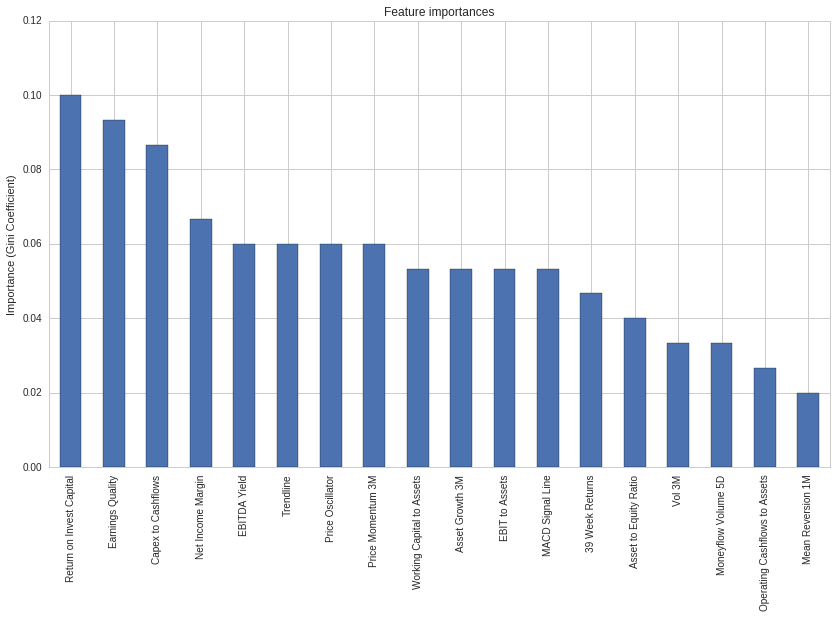

In [42]:
feature_importances.sort(ascending=False)
ax = feature_importances.plot(kind='bar')
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');

*Exercise*: Use [partial dependence plots](http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html) to get an understanding of how factor rankings are used to predict future returns.

## Where to go from here
Several knobs can be tweaked to boost performance:

* Add existing factors from the collection above to the data set.
* Come up with new factors 
  * Use [`alphalens`](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) to evaluate an alpha for its predictive power.
  * Look for [novel data sources from our partners](https://www.quantopian.com/data).
  * Look at the [101 Alpha's Project](https://www.quantopian.com/posts/the-101-alphas-project).
* Improve preprocessing of the ML pipeline
  * Is 70/30 the best split? 
  * Should we not binarize the returns and do regression? 
  * Can we add Sector information in some way?
* Experiment with [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html).
  * PCA
  * ICA
  * etc.
* Tweak hyper-parameters of `AdaBoostClassifier`.
  * [Use cross-validation to find optimal parameters](http://scikit-learn.org/stable/modules/grid_search.html).
* Try [different classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) of combinations of classifiers.

## Machine Learning competition
If you have something you think works well, post it in this thread. Make sure to test over the same time-period as I have here to keep things comparable. In a month from now, we can test on new data that has aggregated since then and determine who built the best ML pipeline. If there is demand, we might turn this into a proper ML contest.

## Machine Learning resources
If you look for information on how to get started with ML, here are a few resources:

* [Scikit-learn resources](http://scikit-learn.org/stable/presentations.html)
* [Learning scikit-learn: Machine Learning in Python](https://www.amazon.com/dp/1783281936)
* [Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)

## How to put this into an algorithm
As mentioned above, this is not immediately usable in an algorithm. For one thing, there is no `run_pipeline()` in the backtest IDE. It turns out to be rather simple to take the code above and put it into a pipeline `CustomFactor()` where the ML model would automatically get retrained and make predictions. You would then long the `1` predictions and short the `-1` predictions, apply some weighting (e.g. inverse variance) and execute orders. More on these next steps in the future.

## Credits
* Content created by James Christopher and Thomas Wiecki
* Thanks to Sheng Wang for ideas and inspiration.
* Jonathan Larkin, Jess Stauth, Delaney Granizo-Mackenzie, and Jean Bredeche for helpful comments on an earlier draft.

In [43]:
y_pred_gradient=np.array([])
y_pred_ada=np.array([])
y_pred_svm=np.array([])
y_pred_l1=np.array([])
y_pred_l2=np.array([])
y_pred_gnb=np.array([])
y_pred_bnb=np.array([])
y_pred_mnb=np.array([])
y_pred_Kmeans=np.array([])
y_pred_rf=np.array([])



# Gradient Boosting Optimization 

In [44]:
"""
#########################warning#######################################################



#########################large Computation##############################################

gsearchTime=time()
from sklearn.ensemble import GradientBoostingClassifier
##GridSearch for GB_Regressor

gbm_param_grid1 = {
   'learning_rate':[0.1,0.2],
    'n_estimators':[50,40,60,70], 
    'max_depth': [5,6,4],
    'min_samples_split': [4,5,6,7],
    'subsample':[0.7,0.6,0.8,0.9]
}
grid_mse = GridSearchCV(GradientBoostingClassifier(), param_grid=gbm_param_grid1,
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X_train_trans,  Y_train_shift)
print("Best parameters: ",grid_mse.best_params_)
print "Time to Gridsearch full ML pipline: %0.2f secs" % (gsearchTime - time()) """

'\n#########################warning#######################################################\n\n\n\n#########################large Computation##############################################\n\ngsearchTime=time()\nfrom sklearn.ensemble import GradientBoostingClassifier\n##GridSearch for GB_Regressor\n\ngbm_param_grid1 = {\n   \'learning_rate\':[0.1,0.2],\n    \'n_estimators\':[50,40,60,70], \n    \'max_depth\': [5,6,4],\n    \'min_samples_split\': [4,5,6,7],\n    \'subsample\':[0.7,0.6,0.8,0.9]\n}\ngrid_mse = GridSearchCV(GradientBoostingClassifier(), param_grid=gbm_param_grid1,\n                        scoring=\'neg_mean_squared_error\', cv=4, verbose=1)\ngrid_mse.fit(X_train_trans,  Y_train_shift)\nprint("Best parameters: ",grid_mse.best_params_)\nprint "Time to Gridsearch full ML pipline: %0.2f secs" % (gsearchTime - time()) '

In [45]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [46]:
a1=  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300,'min_samples_split': 4 ,'subsample':0.6 ,"min_samples_split": 0.15,"min_samples_leaf": 0.15,"max_features":"log2"}
a2=  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 450,'min_samples_split': 3 ,'subsample':0.7 ,"min_samples_split": 0.5,"min_samples_leaf": 0.2,"max_features":"log2"}
a3=  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300,'min_samples_split': 4 ,'subsample':0.6 ,"min_samples_split": 0.15,"min_samples_leaf": 0.15,"max_features":"sqrt"}
a4=  {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 350,'min_samples_split': 4 ,'subsample':0.7 ,"min_samples_split": 0.25,"min_samples_leaf": 0.25,"max_features":"sqrt"}
b1=  {'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 250,'min_samples_split': 4 ,'subsample':0.8 ,"min_samples_split": 0.2,"min_samples_leaf": 0.35,"max_features":"sqrt"}
c=[]
c.append(a1)
c.append(a2)
c.append(a3)
c.append(a4)
c.append(b1)

In [49]:
start= time()
p={}
score=0
for g in c:
    from sklearn.ensemble import GradientBoostingClassifier
    classifier = GradientBoostingClassifier(**g)
    classifier.fit(X_train_trans, Y_train_shift)
    Y_pred_train = classifier.predict(X_train_trans)
    Y_pred_test = classifier.predict(X_test_trans)
    print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
    print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
    score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
    if(score_temp>score):
        p=g
        score=score_temp
        y_pred_gradient=Y_pred_test
end=time()
print("the average time taken" + str((start - end)/len(c)))

Accuracy on train set = 68.77%
Accuracy on test set = 50.93%
Accuracy on train set = 78.89%
Accuracy on test set = 51.39%
Accuracy on train set = 68.55%
Accuracy on test set = 50.93%
Accuracy on train set = 79.22%
Accuracy on test set = 50.90%
Accuracy on train set = 89.73%
Accuracy on test set = 50.96%
the average time taken-20.8186182022


In [50]:
print("the best parameter is"+str(p)+ "with score"+str(score))

the best parameter is{'n_estimators': 450, 'subsample': 0.7, 'max_features': 'log2', 'min_samples_split': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 0.2}with score51.3865686602


# AdaBoost Optimization 

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential'],
    'max_depth': 4,
    'min_samples_split': 4
    
 }

In [52]:
a1=  {  'n_estimators': 150 , 'base_estimator' : DecisionTreeClassifier(max_depth=3) , 'algorithm':'SAMME.R'}
a2=  {'learning_rate': 0.1,  'n_estimators': 450 }
a3=  {'learning_rate': 0.1, 'n_estimators': 300 }
a4=  {'learning_rate': 0.15,  'n_estimators': 350 }
b1=  {'learning_rate': 0.07,  'n_estimators': 250}
c=[]
c.append(a1)
c.append(a2)
c.append(a3)
c.append(a4)
c.append(b1)

In [53]:
start=time()
p={}
score=0
for g in c:
    
    classifier = AdaBoostClassifier(**g)
    classifier.fit(X_train_trans, Y_train_shift)
    Y_pred_train = classifier.predict(X_train_trans)
    Y_pred_test = classifier.predict(X_test_trans)
    print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
    print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
    score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
    if(score_temp>score):
        p=g
        score=score_temp
        y_pred_ada=Y_pred_test
end=time()
print("the average time taken" + str((start - end)/len(c)))    

Accuracy on train set = 69.31%
Accuracy on test set = 51.36%
Accuracy on train set = 55.98%
Accuracy on test set = 50.92%
Accuracy on train set = 55.69%
Accuracy on test set = 50.81%
Accuracy on train set = 56.08%
Accuracy on test set = 50.72%
Accuracy on train set = 55.35%
Accuracy on test set = 50.96%
the average time taken-33.965598011


In [54]:
print("the best parameter is"+str(p)+ "with score"+str(score))

the best parameter is{'n_estimators': 150, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'), 'algorithm': 'SAMME.R'}with score51.3642944649


# SVM Optimization 


In [55]:
from sklearn.svm import SVC

In [56]:
"""class sklearn.svm.SVC(C=1.0, 

kernel= ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ , 
degree=3, 
gamma=’auto_deprecated’, 
coef0=0.0, 
shrinking=True, 
probability=False, 
tol=0.001, 
cache_size=200, 
class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)"""

'class sklearn.svm.SVC(C=1.0, \n\nkernel= \xe2\x80\x98linear\xe2\x80\x99, \xe2\x80\x98poly\xe2\x80\x99, \xe2\x80\x98rbf\xe2\x80\x99, \xe2\x80\x98sigmoid\xe2\x80\x99, \xe2\x80\x98precomputed\xe2\x80\x99 , \ndegree=3, \ngamma=\xe2\x80\x99auto_deprecated\xe2\x80\x99, \ncoef0=0.0, \nshrinking=True, \nprobability=False, \ntol=0.001, \ncache_size=200, \nclass_weight=None, verbose=False, max_iter=-1, decision_function_shape=\xe2\x80\x99ovr\xe2\x80\x99, random_state=None)'

In [57]:
a1=  { 'C':10,'gamma':0.001, 'kernel':'linear'}
a2=  {'C':1,'gamma':0.001, 'kernel':'linear' }
a3=  {'C':1,'gamma':0.001, 'kernel':'rbf' }
a4=  {'C':1000,'gamma':0.0001, 'kernel':'rbf' }
b1=  {'C':1,'gamma':0.0001, 'kernel':'sigmoid'}
c=[]
c.append(a1)
c.append(a2)
c.append(a3)
c.append(a4)
c.append(b1)

In [58]:
start=time()
p={}
score=0
for g in c:
    
    classifier = SVC(**g)
    classifier.fit(X_train_trans, Y_train_shift)
    Y_pred_train = classifier.predict(X_train_trans)
    Y_pred_test = classifier.predict(X_test_trans)
    print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
    print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
    score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
    if(score_temp>score):
        p=g
        score=score_temp
        y_pred_svm=Y_pred_test
end=time()
print("the average time taken" + str((start - end)/len(c)))  

Accuracy on train set = 53.57%
Accuracy on test set = 50.07%
Accuracy on train set = 53.59%
Accuracy on test set = 50.04%
Accuracy on train set = 53.06%
Accuracy on test set = 49.60%
Accuracy on train set = 53.68%
Accuracy on test set = 50.11%
Accuracy on train set = 50.00%
Accuracy on test set = 50.03%
the average time taken-287.535569572


In [59]:
print("the best parameter is"+str(p)+ "with score"+str(score))

the best parameter is{'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}with score50.1058024279


# L1 regularization Logistic Regression 

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
a1=  { 'C':10, 'penalty':'l1'}
a2=  {'C':1, 'penalty':'l1' }
a3=  {'C':.1, 'penalty':'l1' }
a4=  {'C':1000, 'penalty':'l1' }
b1=  {'C':.001, 'penalty':'l1'}
c=[]
c.append(a1)
c.append(a2)
c.append(a3)
c.append(a4)
c.append(b1)

In [62]:
start=time()
p={}
score=0
for g in c:
    
    classifier = LogisticRegression(**g)
    classifier.fit(X_train_trans, Y_train_shift)
    Y_pred_train = classifier.predict(X_train_trans)
    Y_pred_test = classifier.predict(X_test_trans)
    print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
    print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
    score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
    if(score_temp>score):
        p=g
        score=score_temp
        y_pred_l1=Y_pred_test
end=time()
print("the average time taken" + str((start - end)/len(c)))

Accuracy on train set = 54.00%
Accuracy on test set = 50.25%
Accuracy on train set = 53.99%
Accuracy on test set = 50.25%
Accuracy on train set = 53.99%
Accuracy on test set = 50.33%
Accuracy on train set = 54.02%
Accuracy on test set = 50.25%
Accuracy on train set = 50.00%
Accuracy on test set = 50.03%
the average time taken-0.998453998566


In [63]:
print("the best parameter is"+str(p)+ "with score"+str(score))

the best parameter is{'penalty': 'l1', 'C': 0.1}with score50.3285443813


# L2

In [64]:
a1=  { 'C':.1, 'penalty':'l2',"tol":0.0001}
a2=  {'C':1, 'penalty':'l2' }
a3=  {'C':.1, 'penalty':'l2' ,"tol":0.001}
a4=  {'C':.1, 'penalty':'l2' ,"tol":0.01}
b1=  {'C':.1, 'penalty':'l2' ,"tol":0.1}
c=[]
c.append(a1)
c.append(a2)
c.append(a3)
c.append(a4)
c.append(b1)

In [65]:
start= time()
p={}
score=0
for g in c:
    
    classifier = LogisticRegression(**g)
    classifier.fit(X_train_trans, Y_train_shift)
    Y_pred_train = classifier.predict(X_train_trans)
    Y_pred_test = classifier.predict(X_test_trans)
    print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
    print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
    score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
    if(score_temp>score):
        p=g
        score=score_temp
        y_pred_l2=Y_pred_test
end=time()
print("the average time taken" + str((start - end)/len(c))) 

Accuracy on train set = 53.99%
Accuracy on test set = 50.35%
Accuracy on train set = 54.00%
Accuracy on test set = 50.28%
Accuracy on train set = 53.98%
Accuracy on test set = 50.34%
Accuracy on train set = 53.98%
Accuracy on test set = 50.34%
Accuracy on train set = 53.98%
Accuracy on test set = 50.33%
the average time taken-0.146856784821


In [66]:
print("the best parameter is"+str(p)+ "with score"+str(score))

the best parameter is{'penalty': 'l2', 'C': 0.1, 'tol': 0.0001}with score50.3508185767


# NAIVE BAYES Best one selection 

In [69]:
from sklearn.naive_bayes import GaussianNB , BernoulliNB
gnb = GaussianNB()
#cnb=ComplementNB()
bnb= BernoulliNB()

In [70]:
start= time()
gnb.fit(X_train_trans, Y_train_shift)
Y_pred_train = classifier.predict(X_train_trans)
Y_pred_test = classifier.predict(X_test_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
y_pred_gnb=Y_pred_test


end=time()
print("the average time taken" + str(start - end))  

Accuracy on train set = 53.98%
Accuracy on test set = 50.33%
the average time taken-0.0451309680939


In [ ]:
# start= time()
# cnb.fit(X_train_trans, Y_train_shift)
# Y_pred_train = classifier.predict(X_train_trans)
# Y_pred_test = classifier.predict(X_test_trans)
# print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
# print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
# score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
# y_pred_cnb=Y_pred_test


# end=time()
# print("the average time taken" + str(start - end)) 

In [127]:
start= time()
bnb.fit(X_train_trans, Y_train_shift)
Y_pred_train = classifier.predict(X_train_trans)
Y_pred_test = classifier.predict(X_test_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
y_pred_bnb=Y_pred_test


end=time()
print("the average time taken" + str(start - end))  

Accuracy on train set = 68.70%
Accuracy on test set = 50.47%
the average time taken-1.54568505287


# K Means Classify


In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [134]:
start= time()
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train_trans)
clusters = kmeans.predict(X_train_trans)
#le = LabelEncoder()
#y = le.fit_transform(y)
Y_pred_train = kmeans.predict(X_train_trans)
kmeans_pred = kmeans.predict(X_test_trans)



In [135]:
kmeans_pred_2 = []
for x in kmeans_pred:
    if x == 1:
        kmeans_pred_2.append(0)
    elif x == 0:
        kmeans_pred_2.append(1)
        
kmeans_pred_2 = np.array(kmeans_pred_2)

In [136]:
if accuracy_score(kmeans_pred, Y_test_shift, normalize=False) < accuracy_score(kmeans_pred_2, Y_test_shift, normalize=False):
    kmeans_pred = kmeans_pred_2

In [137]:
end=time()
print("the average time taken" + str(start - end))
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, kmeans_pred ) * 100)) 
y_pred_Kmeans=kmeans_pred

the average time taken-1.86274504662
Accuracy on train set = 22.63%
Accuracy on test set = 29.48%


# Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier as rf

In [79]:
"""{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}"""

"{'bootstrap': [True, False],\n 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],\n 'max_features': ['auto', 'sqrt'],\n 'min_samples_leaf': [1, 2, 4],\n 'min_samples_split': [2, 5, 10],\n 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}"

In [117]:
a1=  {'bootstrap': True , 'max_depth': 4, 'n_estimators': 100,'min_samples_split': 4  ,"min_samples_split": 0.15,"min_samples_leaf": 0.15,"max_features":"log2"}
a2=  {'bootstrap': False ,'max_depth': 5, 'n_estimators': 200,'min_samples_split': 3 ,"min_samples_split": 0.5,"min_samples_leaf": 0.2,"max_features":"log2"}
a3=  {'bootstrap': True , 'max_depth': 4, 'n_estimators': 300,'min_samples_split': 4  ,"min_samples_split": 0.15,"min_samples_leaf": 0.15,"max_features":"sqrt"}
a4=  {'bootstrap': False , 'max_depth': 5, 'n_estimators': 350,'min_samples_split': 4 ,"min_samples_split": 0.25,"min_samples_leaf": 0.25,"max_features":"sqrt"}
b1=  {'bootstrap': True , 'max_depth': 8, 'n_estimators': 250,'min_samples_split': 4  ,"min_samples_split": 0.2,"min_samples_leaf": 0.35,"max_features":"sqrt"}
c=[]
c.append(a1)
c.append(a2)
c.append(a3)
c.append(a4)
c.append(b1)

In [118]:
classifier = rf(a1)

In [119]:
start= time()
p={}
score=0
for g in c:
    classifier = rf(**g)
    classifier.fit(X_train_trans, Y_train_shift)
    Y_pred_train = classifier.predict(X_train_trans)
    Y_pred_test = classifier.predict(X_test_trans)
    print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred_train) * 100))
    print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100))
    score_temp=metrics.accuracy_score(Y_test_shift, Y_pred_test) * 100
    if(score_temp>score):
        p=g
        score=score_temp
        y_pred_rf=Y_pred_test
end=time()
print("the average time taken" + str((start - end)/len(c)))

Accuracy on train set = 57.11%
Accuracy on test set = 50.58%
Accuracy on train set = 58.78%
Accuracy on test set = 50.52%
Accuracy on train set = 57.36%
Accuracy on test set = 50.73%
Accuracy on train set = 58.74%
Accuracy on test set = 50.91%
Accuracy on train set = 68.70%
Accuracy on test set = 50.47%
the average time taken-21.1424026012


In [138]:
print("the best parameter is"+str(p)+ "with score"+str(score))

the best parameter is{'bootstrap': False, 'min_samples_leaf': 0.25, 'n_estimators': 350, 'max_features': 'sqrt', 'min_samples_split': 0.25, 'max_depth': 5}with score50.9076734603


# Combining the Four Classifiers

In [ ]:
# y_pred_gradient=np.array([])
# y_pred_ada=np.array([])
# y_pred_svm=np.array([])
# y_pred_l1=np.array([])
# y_pred_l2=np.array([])
# y_pred_gnb=np.array([])
# y_pred_bnb=np.array([])
# y_pred_mnb=np.array([])
# y_pred_Kmeans=np.array([])
# y_pred_rf=np.array([])

In [163]:
df_g =pd.DataFrame( y_pred_gradient)
df_a =pd.DataFrame( y_pred_ada)
df_s =pd.DataFrame( y_pred_svm)
df_l1 =pd.DataFrame( y_pred_l1)
df_l2 =pd.DataFrame( y_pred_l2)
df_gnb =pd.DataFrame( y_pred_gnb)
# df_mgb =pd.DataFrame( y_pred_mgb)
df_bnb =pd.DataFrame( y_pred_bnb)
df_l1 =pd.DataFrame( y_pred_l1)
df_l1 =pd.DataFrame( y_pred_l1)

In [178]:
df = df_g.add(df_a)


In [179]:
df2 = df_s.add(df_l1)

In [180]:
df3=df.add(df2)

In [181]:
y_pre_combined = df3.as_matrix()

In [182]:
df3.max()

0    4.0
dtype: float64

In [183]:
df3.min()

0   -4.0
dtype: float64

In [185]:
y_pre_combined [y_pre_combined <0] =-1
y_pre_combined [y_pre_combined >0] =1

In [186]:
y_pre_combined.max()

1.0

In [187]:
y_pre_combined.min()

-1.0

In [188]:
 np.count_nonzero(y_pre_combined)

7148

In [189]:
Y_test_shift.shape

(8979,)

In [190]:
 print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(y_pre_combined, Y_pred_test) * 100))

Accuracy on test set = 65.53%


In [191]:
sum=0
for i in range(len(y_pre_combined)):
    if (y_pre_combined[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_pre_combined))*100))

accuracy 82.316731953


In [192]:
y_pred_gradient + y_pred_ada

array([ 0., -2.,  0., ...,  0.,  0.,  0.])

In [195]:
y_l1andl2= y_pred_l1 + y_pred_l2
len(y_l1andl2)-np.count_nonzero(y_l1andl2)

142

In [196]:
# y_pred_gradient=np.array([])
# y_pred_ada=np.array([])
# y_pred_svm=np.array([])
# y_pred_l1=np.array([])
# y_pred_l2=np.array([])
# y_pred_gnb=np.array([])
# y_pred_bnb=np.array([])

# y_pred_Kmeans=np.array([])
# y_pred_rf=np.array([])

In [205]:
y_nb_gandb= y_pred_gnb + y_pred_bnb
len(y_nb_gandb)-np.count_nonzero(y_nb_gandb)
y_nb_gandb [y_nb_gandb <0] =-1
y_nb_gandb [y_nb_gandb >0] =1

2421

In [207]:
sum=0
for i in range(len(y_nb_gandb)):
    if (y_nb_gandb[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_nb_gandb))*100))

accuracy 100.0


6558.0

In [209]:
y_nb_gandb= y_pred_gnb + y_pred_bnb+ y_pred_l1 
len(y_nb_gandb)-np.count_nonzero(y_nb_gandb)
y_nb_gandb [y_nb_gandb <0] =-1
y_nb_gandb [y_nb_gandb >0] =1

In [210]:
sum=0
for i in range(len(y_nb_gandb)):
    if (y_nb_gandb[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_nb_gandb))*100))

accuracy 74.0171511304


In [211]:
y_nb_gandb= y_pred_gnb + y_pred_bnb + y_pred_l2
len(y_nb_gandb)-np.count_nonzero(y_nb_gandb)
y_nb_gandb [y_nb_gandb <0] =-1
y_nb_gandb [y_nb_gandb >0] =1

In [212]:
sum=0
for i in range(len(y_nb_gandb)):
    if (y_nb_gandb[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_nb_gandb))*100))

accuracy 73.1039091213


In [213]:
y_nb_gandb= y_pred_gnb + y_pred_bnb + y_pred_l1 + y_pred_gradient
len(y_nb_gandb)-np.count_nonzero(y_nb_gandb)
y_nb_gandb [y_nb_gandb <0] =-1
y_nb_gandb [y_nb_gandb >0] =1

In [214]:
sum=0
for i in range(len(y_nb_gandb)):
    if (y_nb_gandb[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_nb_gandb))*100))

accuracy 88.806672945


In [215]:
y_nb_gandb= y_pred_gnb + y_pred_bnb + y_pred_l1 +y_pred_rf
len(y_nb_gandb)-np.count_nonzero(y_nb_gandb)
y_nb_gandb [y_nb_gandb <0] =-1
y_nb_gandb [y_nb_gandb >0] =1

In [216]:
sum=0
for i in range(len(y_nb_gandb)):
    if (y_nb_gandb[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_nb_gandb))*100))

accuracy 94.0107862617


In [217]:
y_nb_gandb= y_pred_gnb + y_pred_bnb + y_pred_l2 +y_pred_rf
len(y_nb_gandb)-np.count_nonzero(y_nb_gandb)
y_nb_gandb [y_nb_gandb <0] =-1
y_nb_gandb [y_nb_gandb >0] =1

In [218]:
sum=0
for i in range(len(y_nb_gandb)):
    if (y_nb_gandb[i] == Y_pred_test[i]) :
        sum= sum +1
print("accuracy "+ str((float(sum)/ np.count_nonzero(y_nb_gandb))*100))

accuracy 93.8223938224


# so the most efficient and best combination is Combining the following four Classifiers
Random Forest , l1 logistic regression , Naive Bayes (Guassian and Benulli) 
